# Business Understanding

This project aims to create top 5 movie recommendations for each user of the streaming service. The reason to provide movie recommendations, is to enhace the users experience. It is important to keep the users happy while using this streaming service, because there are many streaming services to choose from. 

In addtion this project aims to solve the cold start problem. The cold start problem applies to new users who the company has no historical data about. This cold start problem makes it challenging for companies to personalize movie reccomendations, because there is no past history to base the reccomendations off of. Its important to solve the cold start problem, so new users are impressed with the streaming service, and enjoy their experience. 


# Data Understanding

The dataset for this project can be accessed at https://grouplens.org/datasets/movielens/latest/. In this dataset are users movie ratings ranging from 0.5 to 5 stars. The data set also includes the following:


| Column       | Description                                                   |
|--------------|---------------------------------------------------------------|
| movieId      | Unique identifier for each movie                              |
| title        | Title of the movie along with the release year                |
| genres       | Genres associated with the movie, separated by '|'             |
| userId_x     | User ID of the user who provided the rating                   |
| rating       | Rating given to the movie by the user                         |
| timestamp_x  | Timestamp when the rating was given by the user               |
| userId_y     | User ID of the user who applied the tag                       |
| tag          | Tag applied to the movie by the user                          |
| timestamp_y  | Timestamp when the tag was applied by the user                |
| imdbId       | IMDb ID of the movie                                          |
| tmdbId       | TMDb ID of the movie                                          |


### Importing datasets and libraries needed for notebook

Packages such as Pandas, Numpy, Matplotlib, Surprise, Scikit-learn, and Scipy were used to create models and evaluate performance for both movie recommendations and the cold start problem.

Once the packages were loaded, the four datasets were imported, and an empty dictionary was created to store all four DataFrames. Evaluation of the datasets began by reviewing the number of rows and columns, as well as printing out the first 5 data points from each dataset.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import SVDpp, Dataset, Reader
from surprise.model_selection import cross_validate
from collections import defaultdict
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import Dataset, Reader
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix



# Define the folder path for the "movierec" folder from Desktop
folder_path = os.path.join(os.path.expanduser("~"), "Desktop", "movierec")

# Define file paths for each CSV file within the "movierec" folder
file_paths = {
    'movies': os.path.join(folder_path, 'movies.csv'),
    'links': os.path.join(folder_path, 'links.csv'),
    'ratings': os.path.join(folder_path, 'ratings.csv'),
    'tags': os.path.join(folder_path, 'tags.csv')
}

# Create an empty dictionary to store DataFrames
dfs = {}

# Read each CSV file into a DataFrame and store it in the dictionary
for key, path in file_paths.items():
    dfs[key] = pd.read_csv(path)

# Check the number of rows in each DataFrame and display the first few rows with column names
for key, df in dfs.items():
    print(f"DataFrame: {key}, Number of Rows: {df.shape[0]}")
    print(df.head())  # Display the first few rows of the DataFrame with column names
    print("\n")



DataFrame: movies, Number of Rows: 9742
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


DataFrame: links, Number of Rows: 9742
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0


DataFrame: ratings, Number of Rows: 100836
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  9649812

# Data Preperation

## Ratings

The 'rating' column was reviewed for summary statistics. The mean rating is 3.5 out of 5, suggesting that users generally give positive ratings to movies. However, the standard deviation of 1.04 indicates considerable variability in user ratings, with some users rating movies significantly higher or lower than the average. 

The dataset comprises 610 unique users and 9,724 unique movies. There are no missing values in the 'userId', 'movieId', 'rating', or 'timestamp' columns.


In [2]:
print("Ratings Distribution:\n", dfs['ratings']['rating'].describe())

print("\nUnique Users:", dfs['ratings']['userId'].nunique())
print("Unique Movies:", dfs['ratings']['movieId'].nunique())

# Check for missing values
print("\nMissing Values in Ratings DataFrame:\n", dfs['ratings'].isnull().sum())


Ratings Distribution:
 count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Unique Users: 610
Unique Movies: 9724

Missing Values in Ratings DataFrame:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## Ratings Analysis

### Average Rating per User
The average rating per user was calculated, resulting in a mean rating of 3.66 out of 5. The standard deviation of 0.48 indicates some variability in user ratings, with the minimum and maximum ratings being 1.28 and 5.0, respectively.

### Distribution of Ratings per User
The distribution of ratings showed a wide range in the number of ratings provided by each user. On average, each user provided approximately 165 ratings, with a standard deviation of 269.5. The minimum number of ratings per user was 20, while the maximum was 2698.

### Average Rating per Movie
The average rating per movie was computed, with a mean rating of 3.26 out of 5. Similar to the user ratings, there is some variability in movie ratings, as indicated by the standard deviation of 0.87. The minimum and maximum ratings for movies were 0.5 and 5.0, respectively.

### Distribution of Ratings per Movie
The distribution of ratings per movie was reviewed, revealing that most movies received a relatively low number of ratings. On average, each movie received approximately 10 ratings, with a standard deviation of 22.4. The minimum number of ratings per movie was 1, while the maximum was 329.


In [3]:
# Compute average rating per user
average_ratings_per_user = dfs['ratings'].groupby('userId')['rating'].mean()

# Explore distribution of number of ratings per user
ratings_per_user_distribution = dfs['ratings'].groupby('userId')['rating'].count()

# Compute average rating per movie
average_ratings_per_movie = dfs['ratings'].groupby('movieId')['rating'].mean()

# Explore distribution of ratings per movie
ratings_per_movie_distribution = dfs['ratings'].groupby('movieId')['rating'].count()

# Display results
print("Average Rating per User:\n", average_ratings_per_user.describe())
print("\nDistribution of Ratings per User:\n", ratings_per_user_distribution.describe())
print("\nAverage Rating per Movie:\n", average_ratings_per_movie.describe())
print("\nDistribution of Ratings per Movie:\n", ratings_per_movie_distribution.describe())


Average Rating per User:
 count    610.000000
mean       3.657222
std        0.480635
min        1.275000
25%        3.360000
50%        3.694385
75%        3.997500
max        5.000000
Name: rating, dtype: float64

Distribution of Ratings per User:
 count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: rating, dtype: float64

Average Rating per Movie:
 count    9724.000000
mean        3.262448
std         0.869874
min         0.500000
25%         2.800000
50%         3.416667
75%         3.911765
max         5.000000
Name: rating, dtype: float64

Distribution of Ratings per Movie:
 count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
Name: rating, dtype: float64


## Movie Analysis

This dataset contains a total of 9,742 movies.

### Genres
Movies can belong to multiple genres. For example, 'Toy Story' is categorized as an adventure, animation, children, comedy, and fantasy movie.


In [4]:
# Total Movies
total_movies = len(dfs['movies'])

# Genres
# Inspect the first few rows to understand the genres format
genres_sample = dfs['movies']['genres'].head()

# Year of Release (if available)
# Extract year from title (assuming title format: "Title (Year)")
# Example: "Toy Story (1995)"
dfs['movies']['year'] = dfs['movies']['title'].str.extract(r"\((\d{4})\)")
# Check the first few rows of the modified DataFrame
year_sample = dfs['movies'][['title', 'year']].head()

# Display results
print("Total Movies:", total_movies)
print("\nGenres Sample:\n", genres_sample)
print("\nYear of Release Sample:\n", year_sample)


Total Movies: 9742

Genres Sample:
 0    Adventure|Animation|Children|Comedy|Fantasy
1                     Adventure|Children|Fantasy
2                                 Comedy|Romance
3                           Comedy|Drama|Romance
4                                         Comedy
Name: genres, dtype: object

Year of Release Sample:
                                 title  year
0                    Toy Story (1995)  1995
1                      Jumanji (1995)  1995
2             Grumpier Old Men (1995)  1995
3            Waiting to Exhale (1995)  1995
4  Father of the Bride Part II (1995)  1995


# Data Merging

In this section, the ratings and movies datasets were merged based on the 'movieId' column. The merging process was performed using an inner join to retain only the rows that have matching 'movieId' values in both datasets. This ensures that only ratings for movies present in the movies dataset are included in the merged dataframe.


In [5]:
# Merge ratings and movies dataframes
merged_df = pd.merge(dfs['ratings'], dfs['movies'], on='movieId', how='inner')

# Display the first few rows of the merged dataframe
print("Merged DataFrame Sample:\n", merged_df.head())


# Example: Ratings by genre
ratings_by_genre = merged_df.groupby('genres')['rating'].mean().sort_values(ascending=False)
print("\nAverage Ratings by Genre:\n", ratings_by_genre)

# Example: Ratings trend over the years
ratings_by_year = merged_df.groupby('year')['rating'].mean()
print("\nAverage Ratings Over the Years:\n", ratings_by_year)



Merged DataFrame Sample:
    userId  movieId  rating   timestamp             title  \
0       1        1     4.0   964982703  Toy Story (1995)   
1       5        1     4.0   847434962  Toy Story (1995)   
2       7        1     4.5  1106635946  Toy Story (1995)   
3      15        1     2.5  1510577970  Toy Story (1995)   
4      17        1     4.5  1305696483  Toy Story (1995)   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1  Adventure|Animation|Children|Comedy|Fantasy  1995  
2  Adventure|Animation|Children|Comedy|Fantasy  1995  
3  Adventure|Animation|Children|Comedy|Fantasy  1995  
4  Adventure|Animation|Children|Comedy|Fantasy  1995  

Average Ratings by Genre:
 genres
Fantasy|Mystery|Western                5.0
Animation|Children|Mystery             5.0
Comedy|Horror|Mystery                  5.0
Animation|Drama|Fantasy|Mystery        5.0
Drama|Horror|Romance                   5.0
                                 

In [6]:
print(merged_df['year'].unique())


['1995' '1996' '1994' '1977' '1993' '1990' '1989' '1991' '1940' '1939'
 '1941' '1938' '1947' '1975' '1968' '1945' '1963' '1971' '1951' '1979'
 '1992' '1986' '1982' '1980' '1987' '1981' '1983' '1960' '1952' '1984'
 '1933' '1985' '1974' '1922' '1997' '1998' '1930' '1976' '1942' '1967'
 '1959' '1946' '1978' '1973' '1988' '1999' '1931' '1964' '1962' '1965'
 '1969' '2000' '1970' '2003' '2004' '2006' '2008' '2009' '2010' '2011'
 '2012' '2013' '2014' '2015' '1955' '2002' '1961' '1954' '1957' '1943'
 '1956' '1966' '2001' '1937' '1972' '2005' '1950' '2007' '2016' '1926'
 '1944' '1949' '1936' '2017' '1958' '1935' '1927' '1953' '2018' '1923'
 '1902' '1920' '1948' '1928' nan '1934' '1916' '1908' '1932' '1921' '1925'
 '1929' '1917' '1915' '1924' '1903' '1919']


# Data Transformation

## Conversion of 'year' Column
The 'year' column in the merged dataframe was converted to numeric format using the `pd.to_numeric()` function. Any 'nan' values were replaced with zeros and then converted to integer data type. This conversion allows for easier manipulation and analysis of movie release years.

# Visualizations

## Average Ratings per User Over Time (Decade)
This line plot shows user engagement, showing the average ratings given by users for each decade. The trend revealed that average ratings were consistently above 3.6 after the 1920s, with a peak around 3.9 in the 1970s. A noticeable dip occurred in the 1980s, with average ratings descending to around 3.6. Post 1990's there has been an increase in ratings , that seems to be continuing to grow which indicates a postive shift in likeability of movies. 

## Average Ratings per Movie Over Time (Decade)



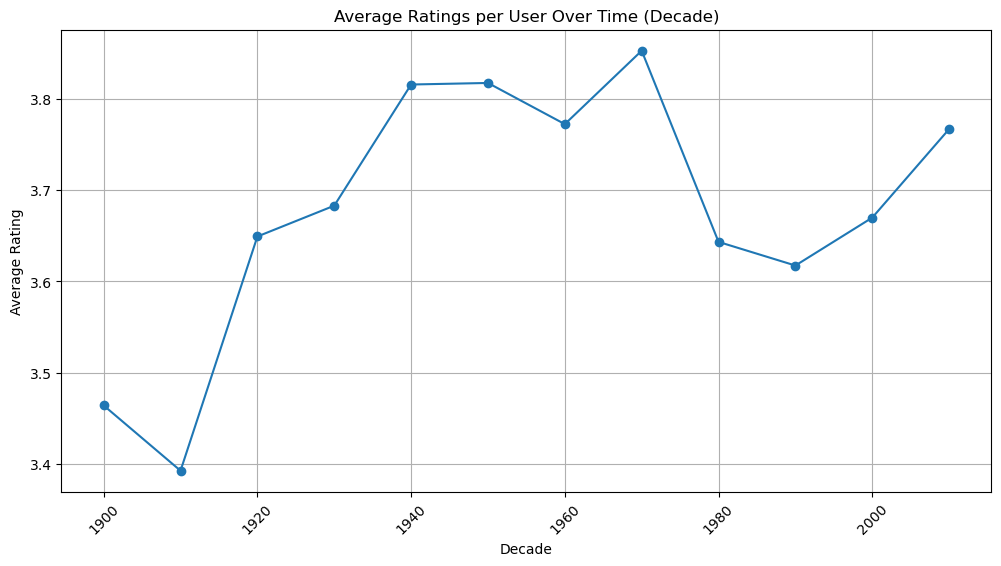

In [7]:
# Convert 'year' column to numeric, replacing 'nan' with zeros
merged_df['year'] = pd.to_numeric(merged_df['year'], errors='coerce').fillna(0).astype(int)

# Aggregate data by decade
merged_df['decade'] = (merged_df['year'] // 10) * 10

# Replace zeros with 'nan' values
merged_df.loc[merged_df['year'] == 0, 'decade'] = np.nan

## Correct calculation for average ratings per user per decade
ratings_per_user_over_decade = merged_df.groupby(['decade', 'userId'])['rating'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(ratings_per_user_over_decade.groupby('decade')['rating'].mean(), marker='o', linestyle='-')
plt.title('Average Ratings per User Over Time (Decade)')
plt.xlabel('Decade')
plt.ylabel('Average Rating')  
plt.grid(True)
plt.xticks(rotation=45)
plt.show()





# Additional Data Merging

## Tags Dataset Integration

The tags dataset has been merged with the existing merged DataFrame to incorporate user-generated tags applied to movies. 

## Missing Values Check

- **userId_y**: 52,549 missing values
- **tag**: 52,549 missing values
- **timestamp_y**: 52,549 missing values


In [8]:
# Load the remaining datasets
links_df = pd.read_csv(file_paths['links'])
tags_df = pd.read_csv(file_paths['tags'])

# Display the first few rows of each dataset to understand their contents
print("Links Dataset:\n", links_df.head())
print("\nTags Dataset:\n", tags_df.head())


Links Dataset:
    movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

Tags Dataset:
    userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200


In [9]:
# Load the remaining datasets
links_df = pd.read_csv(file_paths['links'])
tags_df = pd.read_csv(file_paths['tags'])

# Merge tags dataset
merged_df = pd.merge(merged_df, tags_df, on='movieId', how='left')

# Display the first few rows of the updated merged DataFrame
print("Updated Merged DataFrame:\n", merged_df.head())

# Check for any missing values after merging
print("\nMissing Values in Merged DataFrame:\n", merged_df.isnull().sum())


Updated Merged DataFrame:
    userId_x  movieId  rating  timestamp_x             title  \
0         1        1     4.0    964982703  Toy Story (1995)   
1         1        1     4.0    964982703  Toy Story (1995)   
2         1        1     4.0    964982703  Toy Story (1995)   
3         5        1     4.0    847434962  Toy Story (1995)   
4         5        1     4.0    847434962  Toy Story (1995)   

                                        genres  year  decade  userId_y    tag  \
0  Adventure|Animation|Children|Comedy|Fantasy  1995  1990.0     336.0  pixar   
1  Adventure|Animation|Children|Comedy|Fantasy  1995  1990.0     474.0  pixar   
2  Adventure|Animation|Children|Comedy|Fantasy  1995  1990.0     567.0    fun   
3  Adventure|Animation|Children|Comedy|Fantasy  1995  1990.0     336.0  pixar   
4  Adventure|Animation|Children|Comedy|Fantasy  1995  1990.0     474.0  pixar   

    timestamp_y  
0  1.139046e+09  
1  1.137207e+09  
2  1.525286e+09  
3  1.139046e+09  
4  1.137207e+09  

### Discription Table

The below shows the columns and their discription. 

In [10]:
# Print all the columns of the merged DataFrame
print(merged_df.columns)

Index(['userId_x', 'movieId', 'rating', 'timestamp_x', 'title', 'genres',
       'year', 'decade', 'userId_y', 'tag', 'timestamp_y'],
      dtype='object')


| Column                | Description                                                    |
|-----------------------|----------------------------------------------------------------|
| movieId               | Unique identifier for each movie                               |
| title                 | Title of the movie along with the release year                 |
| genres                | Genres associated with the movie, separated by '|'            |
| userId_x              | User ID of the user who provided the rating                    |
| rating                | Rating given to the movie by the user                          |
| timestamp_x           | Timestamp when the rating was given by the user                |
| userId_y              | User ID of the user who applied the tag                        |
| tag                   | Tag applied to the movie by the user                           |
| timestamp_y           | Timestamp when the tag was applied by the user                 |
| imdbId                | IMDb ID of the movie                                            |
| tmdbId                | TMDb ID of the movie                                            |


# Handling Missing Values

Before handling missing values, the DataFrame had **285,762** rows. After handling missing values:

- The 'tag' column was filled with 'Unknown' for missing values.
- Rows with missing values in the 'userId_y' and 'timestamp_y' columns were dropped.

As a result, the DataFrame now contains **233,213** rows.


In [11]:
# Before handling missing values
num_rows_before_handling = merged_df.shape[0]

# Handling missing values
# Fill missing values in the 'tag' column with 'Unknown'
merged_df['tag'].fillna('Unknown', inplace=True)
# Drop rows with missing values in 'userId_y' and 'timestamp_y' columns
merged_df.dropna(subset=['userId_y', 'timestamp_y'], inplace=True)

# After handling missing values
num_rows_after_handling = merged_df.shape[0]

# Print the number of rows before and after handling missing values
print("Number of Rows Before Handling Missing Values:", num_rows_before_handling)
print("Number of Rows After Handling Missing Values:", num_rows_after_handling)


Number of Rows Before Handling Missing Values: 285762
Number of Rows After Handling Missing Values: 233213


In [12]:
# Summary Statistics
summary_statistics = merged_df.describe()
print(summary_statistics)


            userId_x        movieId         rating   timestamp_x  \
count  233213.000000  233213.000000  233213.000000  2.332130e+05   
mean      309.688191   12319.999443       3.966535  1.213524e+09   
std       178.206387   28243.919401       0.968637  2.250448e+08   
min         1.000000       1.000000       0.500000  8.281246e+08   
25%       156.000000     296.000000       3.500000  1.017365e+09   
50%       309.000000    1198.000000       4.000000  1.217325e+09   
75%       460.000000    4638.000000       5.000000  1.443201e+09   
max       610.000000  193565.000000       5.000000  1.537799e+09   

                year         decade       userId_y   timestamp_y  
count  233213.000000  233210.000000  233213.000000  2.332130e+05  
mean     1994.409235    1989.839329     470.683564  1.384774e+09  
std        13.725812      12.033468     153.329632  1.534621e+08  
min         0.000000    1920.000000       2.000000  1.137179e+09  
25%      1994.000000    1990.000000     424.000000  

## Visualization of Distribution of Ratings

This bar graph clearly shows that most users are giving movies 3-5 star ratings. The number of 3-star ratings is close to 30k, while anything below 3 is well below the 10k mark. The highest frequency of ratings is 4 stars, and the second highest frequency is 5 stars. The lowest frequency is for movies rated 1.5 stars. This data indicates that users tend to rate movies positively, and the data is skewed towards higher ratings.



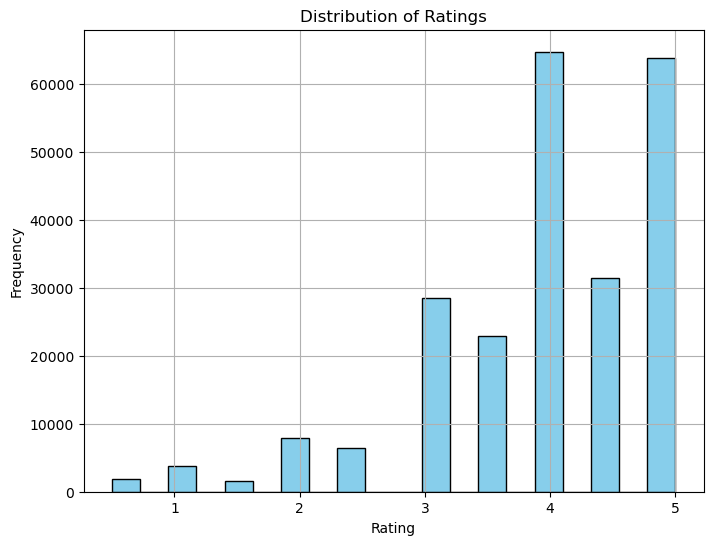

In [13]:
import matplotlib.pyplot as plt

# Histogram of Ratings
plt.figure(figsize=(8, 6))
plt.hist(merged_df['rating'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


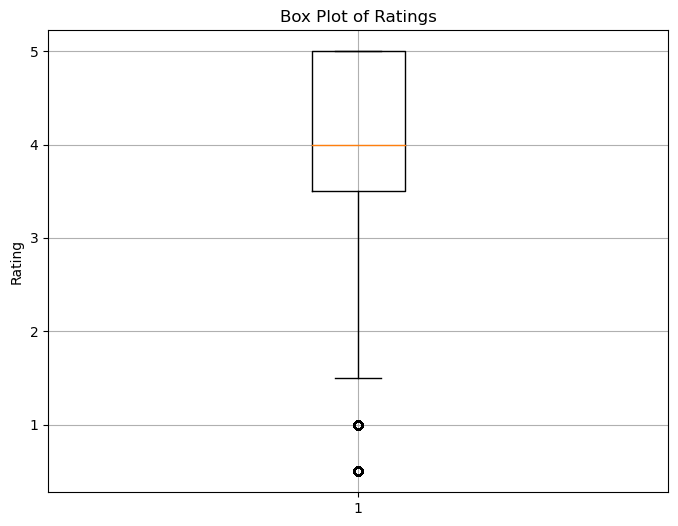

In [14]:
# Box Plot of Ratings
plt.figure(figsize=(8, 6))
plt.boxplot(merged_df['rating'])
plt.title('Box Plot of Ratings')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


## Check for Missing Values
The dataset was examined for missing values. The 'decade' column had 3 missing values.

### Fill missing values in 'decade' column based on 'year' information
The missing values in the 'decade' column were filled by deriving decade information from the 'year' column.

No rows were found with missing 'decade' values after filling them.

There are now 0 missing values in the 'decade' column.


In [15]:
# Check for Missing Values
missing_values = merged_df.isnull().sum()
print("Missing Values:\n", missing_values)


Missing Values:
 userId_x       0
movieId        0
rating         0
timestamp_x    0
title          0
genres         0
year           0
decade         3
userId_y       0
tag            0
timestamp_y    0
dtype: int64


In [16]:
# Fill missing values in 'decade' column based on 'year' information
merged_df['decade'] = (merged_df['year'] // 10) * 10
# Display rows with missing 'decade' values
missing_decade_rows = merged_df[merged_df['decade'].isnull()]
print(missing_decade_rows)


Empty DataFrame
Columns: [userId_x, movieId, rating, timestamp_x, title, genres, year, decade, userId_y, tag, timestamp_y]
Index: []


In [17]:
print(merged_df['decade'].isnull().sum())


0


## Analysis of Genres

### Unique Genres
The dataset was analyzed to identify unique genres. The following genres were found: {'Film-Noir', 'Crime', 'Sci-Fi', 'Mystery', 'Documentary', 'Comedy', 'Horror', 'Animation', '(no genres listed)', 'Drama', 'IMAX', 'Western', 'Romance', 'Musical', 'Fantasy', 'Action', 'War', 'Adventure', 'Thriller', 'Children'}.

### Movies with "(no genres listed)"
There were 3 movies with the label '(no genres listed)', accounting for 0.00% of the total movies in the dataset.

### Removal of Movies with "(no genres listed)"
The movies with the label '(no genres listed)' were removed from the dataset. After removal, the updated DataFrame contained the following unique genres: ['Film-Noir' 'Crime' 'Thriller' 'Mystery' 'Documentary' 'Comedy' 'Horror'
 'Animation' 'Drama' 'Sci-Fi' 'IMAX' 'Western' 'Romance' 'Musical'
 'Fantasy' 'Action' 'War' 'Adventure' 'Children'].

The updated DataFrame shape is (233210, 11).


In [18]:
# Extract unique genres
unique_genres = set()

for genres in merged_df['genres']:
    unique_genres.update(genres.split('|'))

print("Unique Genres:", unique_genres)


Unique Genres: {'Fantasy', 'Drama', 'IMAX', 'Documentary', 'Mystery', 'Crime', 'Sci-Fi', 'Horror', 'Comedy', 'Children', 'Thriller', 'Film-Noir', 'War', 'Adventure', 'Animation', 'Western', 'Action', 'Romance', '(no genres listed)', 'Musical'}


In [19]:
# Count occurrences of "(no genres listed)"
no_genre_count = merged_df[merged_df['genres'] == '(no genres listed)'].shape[0]
total_movies = merged_df.shape[0]

# Calculate percentage of movies with "(no genres listed)"
percentage_no_genre = (no_genre_count / total_movies) * 100

print("Number of movies with '(no genres listed)':", no_genre_count)
print("Percentage of movies with '(no genres listed)': {:.2f}%".format(percentage_no_genre))


Number of movies with '(no genres listed)': 3
Percentage of movies with '(no genres listed)': 0.00%


In [20]:
# Remove movies with '(no genres listed)' label
merged_df = merged_df[merged_df['genres'] != '(no genres listed)']

# Verify the removal by checking the unique genres again
unique_genres_after_removal = merged_df['genres'].unique()
print("Unique Genres After Removal:", unique_genres_after_removal)

# Display the updated DataFrame shape
print("Updated DataFrame Shape:", merged_df.shape)


Unique Genres After Removal: ['Adventure|Animation|Children|Comedy|Fantasy' 'Comedy|Romance'
 'Mystery|Thriller' 'Crime|Mystery|Thriller'
 'Adventure|Comedy|Crime|Romance' 'Action|Drama|War' 'Comedy'
 'Comedy|Drama' 'Action|Adventure|Sci-Fi' 'Comedy|Crime|Drama|Thriller'
 'Action|Crime|Drama|Thriller' 'Comedy|Drama|Romance|War' 'Thriller'
 'Action|Adventure|Sci-Fi|Thriller' 'Drama|War' 'Comedy|Romance|Thriller'
 'Action|Adventure|Comedy|Romance' 'Adventure|Drama|Western'
 'Action|Crime|Thriller' 'Crime|Horror|Thriller'
 'Animation|Children|Fantasy|Musical' 'Action|Adventure|Mystery|Thriller'
 'Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi'
 'Action|Adventure|Thriller' 'Action|Adventure|Romance|Thriller'
 'Adventure|Children|Fantasy|Musical' 'Drama|Mystery'
 'Action|Adventure|Romance' 'Drama|Fantasy|Romance' 'Drama'
 'Animation|Children|Drama|Musical' 'Adventure|Animation|Children|Musical'
 'Adventure|Animation|Children|Fantasy|Musical' 'Children|Drama|Sci-Fi'
 'Adventure|Comedy|Fa

## Genre Analysis with Dummy Variables

To allow our modeling to work, categorical genre information was changed into numerical dummy variables. This allows us to quantify the presence of each genre for every movie in our dataset.



In [21]:
#DataFrame with binary columns for each genre
genres_dummies = merged_df['genres'].str.get_dummies(sep='|')
# Concatenate the dummy DataFrame with the original one
merged_df = pd.concat([merged_df, genres_dummies], axis=1)
# Drop the original 'genres' column
merged_df.drop('genres', axis=1, inplace=True)
print(merged_df.columns)


Index(['userId_x', 'movieId', 'rating', 'timestamp_x', 'title', 'year',
       'decade', 'userId_y', 'tag', 'timestamp_y', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


# Model Building
Three models were built to create movie reccomendations. SVD, SVD with Grid Search, and LightFM

To prepare the dataset for modeling, we defined a reader object to parse the ratings on a scale from 0.5 to 5.0. The dataset was then loaded into Surprise's Dataset object.

We first used the Singular Value Decomposition (SVD) algorithm for collaborative filtering-based recommendation. The algorithm was evaluated using cross-validation with 5 folds, measuring Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE).

The SVD algorithm was trained on the entire dataset to generate 5 movie recommendations per user.


## Modeling SVD

This summary provides insights into the performance of the SVD algorithm for movie rating prediction:
## Recommendation System Performance Summary

| Metric              | Value |
|---------------------|-------|
| **Mean F1 Score**   | 0.106 |
| **Average Precision** | 0.983 |
| **Average Recall**  | 0.293 |
| **RMSE**            | 0.399 |
| **MAE**             | 0.2598 |

### Evaluation Summary
The system exhibits high precision, indicating it effectively recommends items users like. However, the disparity between precision and recall, alongside a low F1 score, reveals challenges in covering the full spectrum of user interests. While RMSE and MAE show reasonable accuracy in rating predictions, there is potential for enhancing recommendation inclusivity.

### Impact of Rating Distribution
The skew towards positive ratings (above 3) in the dataset likely influences the observed performance metrics. This skew might cause the system to prioritize recommending universally liked items, thus achieving high precision. However, this approach can reduce the system's recall by not surfacing more niche or diverse content that could be relevant but less universally acclaimed, limiting recommendation diversity and potentially user satisfaction.

Fit Time: The algorithm took an average of 14.44 seconds to train on the dataset. The standard deviation of 1.06 seconds indicates some variability in training time across folds. 

Test Time: It took an average of 0.43 seconds to generate predictions on the test set. The standard deviation of 0.06 seconds suggests consistent prediction time across folds.



In [22]:
# Define the Reader object
reader = Reader(rating_scale=(1, 5))  

# Load dataset into Surprise's Dataset object
data = Dataset.load_from_df(merged_df[['userId_x', 'movieId', 'rating']], reader=reader)

# Print information about the dataset
print("Number of users:", data.build_full_trainset().n_users)
print("Number of items:", data.build_full_trainset().n_items)
print("Number of ratings:", data.build_full_trainset().n_ratings)


Number of users: 610
Number of items: 1553
Number of ratings: 233210


In [23]:
# Define a Reader object to parse the ratings
reader = Reader(rating_scale=(0.5, 5.0))

# Load the dataset
data = Dataset.load_from_df(merged_df[['userId_x', 'movieId', 'rating']], reader)

# Define the SVD algorithm
svd = SVD()

# Perform cross-validation
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Train the SVD algorithm on the whole dataset
trainset = data.build_full_trainset()
svd.fit(trainset)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3904  0.4056  0.4034  0.4100  0.4020  0.4023  0.0065  
MAE (testset)     0.2387  0.2700  0.2682  0.2723  0.2696  0.2638  0.0126  
Fit time          14.44   13.56   13.54   13.92   13.53   13.80   0.35    
Test time         0.35    0.31    0.32    0.31    0.33    0.32    0.01    


In [24]:
from surprise import accuracy
from collections import defaultdict

# Function to calculate precision and recall for each threshold
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''
    
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

# Use the SVD algorithm trained on the whole dataset to predict the testset
predictions = svd.test(trainset.build_testset())

# Calculate precision and recall at k
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)

# Calculate F1 score for each user
f1_scores = {uid: 2 * (precisions[uid] * recalls[uid]) / (precisions[uid] + recalls[uid])
             if (precisions[uid] + recalls[uid]) != 0 else 0
             for uid in precisions}

# To get a single measure, we average over all users.
f1_mean = sum(f1_scores.values()) / len(f1_scores)

print(f'Mean F1 score for all users: {f1_mean}')


Mean F1 score for all users: 0.10793913518491899


In [25]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
import numpy as np


# Calculate the mean rating
mean_rating = merged_df['rating'].mean()

# Initialize a reader and read in the data
reader = Reader(rating_scale=(.5, 5))  
data = Dataset.load_from_df(merged_df[['userId_x', 'movieId', 'rating']], reader)

# Split the dataset for training and testing
trainset, testset = train_test_split(data, test_size=0.25)

# Use the SVD algorithm, train it, and predict
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

# Function to calculate precision and recall at k
def precision_recall_at_k(predictions, k=10, threshold=mean_rating):
    '''Return precision and recall at k metrics for each user.'''
    # First map the predictions to each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=mean_rating)

# Calculate average precision and recall across all users
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")


Average Precision: 0.9913181390977442
Average Recall: 0.29124318976003505


#### Example of how the model recommends movies

In [26]:
from surprise import Dataset, Reader
from surprise import SVD
import pandas as pd

# Define a Reader object to parse the ratings
reader = Reader(rating_scale=(0.5, 5.0))

# Load the dataset
data = Dataset.load_from_df(merged_df[['userId_x', 'movieId', 'rating']], reader)

# Define the SVD algorithm
svd = SVD()

# Train the SVD algorithm on the whole dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

# Function to get top N recommendations for a user
def get_top_n_recommendations(user_id, n=5):
    user_movies = merged_df[merged_df['userId_x'] == user_id]['movieId']
    movies_to_recommend = merged_df[~merged_df['movieId'].isin(user_movies)]['movieId'].unique()
    predictions = [(movie_id, svd.predict(user_id, movie_id).est) for movie_id in movies_to_recommend]
    top_n_recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]
    return top_n_recommendations

# Define the list of users
users_to_recommend = [1, 10, 100, 200, 300]

# Print top 5 recommendations for each user
for user_id in users_to_recommend:
    recommendations = get_top_n_recommendations(user_id)
    movie_titles = [dfs['movies'][dfs['movies']['movieId'] == movie_id]['title'].values[0] for movie_id, _ in recommendations]
    print(f"User {user_id} recommendations:")
    for idx, movie_title in enumerate(movie_titles, start=1):
        print(f"{idx}. {movie_title}")
    print()


User 1 recommendations:
1. Shawshank Redemption, The (1994)
2. Inside Job (2010)
3. Dark Knight Rises, The (2012)
4. Crumb (1994)
5. Singin' in the Rain (1952)

User 10 recommendations:
1. Avengers, The (2012)
2. Captain Fantastic (2016)
3. Enemy at the Gates (2001)
4. WALL·E (2008)
5. North by Northwest (1959)

User 100 recommendations:
1. Schindler's List (1993)
2. Grave of the Fireflies (Hotaru no haka) (1988)
3. Serenity (2005)
4. Patton (1970)
5. Dallas Buyers Club (2013)

User 200 recommendations:
1. Usual Suspects, The (1995)
2. Wild Tales (2014)
3. Guess Who's Coming to Dinner (1967)
4. Departed, The (2006)
5. This Is Spinal Tap (1984)

User 300 recommendations:
1. There Will Be Blood (2007)
2. Lawrence of Arabia (1962)
3. 12 Angry Men (1957)
4. Bridge on the River Kwai, The (1957)
5. Guess Who's Coming to Dinner (1967)



## MODELING WITH SVD GRIDSEARCH

### Hyperparameter Tuning
A parameter grid was created to explore a wide range of combinations, aiming to find the best model based on Root Mean Square Error (RMSE) and Mean Absolute Error (MAE).

The grid search was used to evaluate across 5-fold cross-validation to ensure reliability of the modeling.

### Results

**Best Parameters:**
- **Number of Latent Factors (`n_factors`)**: 150
- **Number of Epochs (`n_epochs`)**: 40
- **Learning Rate (`lr_all`)**: 0.005
- **Regularization Term (`reg_all`)**: 0.02
- **Bias Term (`biased`)**: True

**Performance Scores:**
- **Best RMSE (Root Mean Square Error) Score**: 0.3694
- **Best MAE (Mean Absolute Error) Score**: 0.2294

The grid search optimization of the SVD model substantially improved our movie recommendation system, despite the significant computational effort required. This model took several hours to run and might not be ideal for making movie recommendations instantly. However, the hyperparameters enhanced prediction accuracy and optimized the balance between recall and precision. This modeling technique could be useful with more powerful computers or platforms like Google Cloud, which can decrease the modeling time. It's important to note that once the model was chosen from the grid, the timing wasn't much different from the first SVD.

In [27]:

# Define the parameter grid
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.04, 0.06],
    'biased': [True, False]  # 
}

# Initialize Grid Search
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)

# Run Grid Search
grid_search.fit(data)


# Run Grid Search
grid_search.fit(data)

# Output the best parameters and RMSE score
print("Best parameters:", grid_search.best_params['rmse'])
print("Best RMSE score:", grid_search.best_score['rmse'])

# Get the best model
best_model = grid_search.best_estimator['rmse']


Best parameters: {'n_factors': 150, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.02, 'biased': True}
Best RMSE score: 0.35988194061370915


In [28]:

print(merged_df.columns)


Index(['userId_x', 'movieId', 'rating', 'timestamp_x', 'title', 'year',
       'decade', 'userId_y', 'tag', 'timestamp_y', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


In [29]:
# Best parameters from grid search
best_params = {
    'n_factors': 150, 
    'n_epochs': 40, 
    'lr_all': 0.005, 
    'reg_all': 0.02, 
    'biased': True
}

# Initialize the SVD model with the best parameters
algo = SVD(
    n_factors=best_params['n_factors'],
    n_epochs=best_params['n_epochs'],
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    biased=best_params['biased']
)
from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV
from surprise import SVD
from collections import defaultdict

# Define the Reader with the appropriate scale for your dataset
reader = Reader(rating_scale=(1, 5))

# Load the dataset from the dataframe using load_from_df method
# Replace 'merged_df' with your actual dataframe variable name and ensure the column names match
data = Dataset.load_from_df(merged_df[['userId_x', 'movieId', 'rating']], reader)

# Train the SVD algorithm on the full dataset
algo.fit(trainset)

# Generate predictions for all pairs (user, items) not in the training set
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

def get_top_n(predictions, n=5):
    '''Return the top-N recommendations for each user from a set of predictions.'''
    top_n = defaultdict(list)
    for uid, iid, _, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=5)

# Create a mapping from movie IDs to titles
movie_id_to_title = merged_df[['movieId', 'title']].drop_duplicates().set_index('movieId')['title'].to_dict()

# Print the recommended movie titles for the first 5 users
for uid, user_ratings in list(top_n.items())[:5]:  
    print(f"User {uid} recommendations:")
    for iid, _ in user_ratings:
        title = movie_id_to_title.get(iid, "Title not found")
        print(f"\t- {title}")


User 1 recommendations:
	- Shawshank Redemption, The (1994)
	- Dark Knight Rises, The (2012)
	- Patton (1970)
	- Philadelphia Story, The (1940)
	- Casablanca (1942)
User 5 recommendations:
	- Guess Who's Coming to Dinner (1967)
	- Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion Gekijô-ban: Air/Magokoro wo, kimi ni) (1997)
	- Graduate, The (1967)
	- Shadow of a Doubt (1943)
	- Bonnie and Clyde (1967)
User 7 recommendations:
	- Godfather, The (1972)
	- Sausage Party (2016)
	- Argo (2012)
	- To Kill a Mockingbird (1962)
	- High Noon (1952)
User 15 recommendations:
	- To Kill a Mockingbird (1962)
	- It's a Wonderful Life (1946)
	- Bridge on the River Kwai, The (1957)
	- Godfather: Part II, The (1974)
	- Paths of Glory (1957)
User 17 recommendations:
	- Cyrano de Bergerac (1990)
	- Creature Comforts (1989)
	- Great Escape, The (1963)
	- Shadow of a Doubt (1943)
	- To Kill a Mockingbird (1962)


In [30]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
import numpy as np


# Define the Reader and load the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_df[['userId_x', 'movieId', 'rating']], reader)

# Split the dataset into train and test sets for evaluation
trainset, testset = train_test_split(data, test_size=0.25)

# Initialize the SVD model with the best parameters
algo = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'],
           lr_all=best_params['lr_all'], reg_all=best_params['reg_all'], biased=best_params['biased'])

# Train the SVD algorithm on the training set
algo.fit(trainset)

# Predict on the test set
predictions = algo.test(testset)

# Calculate and print out RMSE and MAE
accuracy.rmse(predictions)
accuracy.mae(predictions)

# Function to calculate precision, recall, and F1
def precision_recall_f1_at_k(predictions, k=10, threshold=3.5):
    '''Return precision, recall, and F1 at k metrics for each user.'''
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    # Calculate F1 score
    f1_scores = {uid: 2*(precisions[uid]*recalls[uid])/(precisions[uid]+recalls[uid]) if (precisions[uid]+recalls[uid]) != 0 else 0 for uid in precisions}

    return precisions, recalls, f1_scores

# Calculate precision, recall, and F1 score
precisions, recalls, f1_scores = precision_recall_f1_at_k(predictions)

# Calculate average precision, recall, and F1 score
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)
avg_f1 = sum(f1 for f1 in f1_scores.values()) / len(f1_scores)

print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")


RMSE: 0.3802
MAE:  0.2416
Average Precision: 0.9804910469935096
Average Recall: 0.3408053507504015
Average F1 Score: 0.4226065123025282


## Modeling with Lightfm

LightFM is a hybrid machine learning model, used for making recommendations by learning from both user and item features. This means it doesn't just rely on past interactions between users and items but also considers additional details, like user preferences and item characteristics, to make smarter recommendations.  

After applying the LightFM model to our movie recommendation system, we evaluated its performance based on several key metrics. The dataset used for this evaluation consists of user IDs, movie IDs, and ratings, used to predict how well the model recommends movies to users. 

The LightFM AUC,, and percision score indicates the model has a strong ability to recommend relevant movies to users. The model has a low recall score, which indicates it's capturing a smaller portion of relevant items. Its possible that this model could benefit from reviewing a wider range of data, maybe including tags or genres. 


## Performance Metrics Summary

| Metric                  | Training Set       | Test Set           |
|-------------------------|--------------------|--------------------|
| **Precision@k**         | 0.6695             | 0.5871             |
| **Recall@k**            | 0.0849             | 0.1479             |
| **AUC**                 | 0.9358             | 0.9376             |



In [31]:
# Print out the column names of the merged_df DataFrame
print(merged_df.columns)


Index(['userId_x', 'movieId', 'rating', 'timestamp_x', 'title', 'year',
       'decade', 'userId_y', 'tag', 'timestamp_y', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


In [32]:
from lightfm import LightFM
from lightfm.data import Dataset
import numpy as np

# Create a dataset
dataset = Dataset()
dataset.fit(users=(x for x in merged_df['userId_x']),
            items=(x for x in merged_df['movieId']))

# Build the interaction matrix
(interactions, weights) = dataset.build_interactions(((row['userId_x'], row['movieId'], row['rating']) for index, row in merged_df.iterrows()))



/Users/jguzzo522/anaconda3/envs/learn-env/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [33]:
model = LightFM(loss='warp')
model.fit(interactions, sample_weight=weights, epochs=30)



In [34]:
def make_recommendations_with_titles(model, data, user_ids, merged_df, num_items=5):
    # Mapping from dataset
    user_id_map, user_feature_map, item_id_map, item_feature_map = data.mapping()
    
    # Reverse the item_id_map to find item IDs based on internal indices
    item_id_inverse_map = {v: k for k, v in item_id_map.items()}
    
    for user_id in user_ids:
        # Get the internal ID of the user
        user_internal_id = user_id_map.get(user_id)
        if user_internal_id is None:
            print(f"User ID {user_id} not found.")
            continue
        
        # Predict the scores
        scores = model.predict(user_internal_id, np.arange(len(item_id_map)))
        
        # Rank the items
        top_items_indices = np.argsort(-scores)[:num_items]
        
        # Convert the indices back to item IDs
        top_item_ids = [item_id_inverse_map[x] for x in top_items_indices]
        
        # Get the corresponding titles
        top_movie_titles = merged_df[merged_df['movieId'].isin(top_item_ids)]['title'].unique().tolist()
        
        print(f"\nTop {num_items} recommendations for user {user_id}:")
        for title in top_movie_titles:
            print(f"   {title}")



In [35]:

first_5_user_ids = merged_df['userId_x'].unique()[:5]

# Call the recommendation function
make_recommendations_with_titles(model, dataset, user_ids=first_5_user_ids, merged_df=merged_df)



Top 5 recommendations for user 1:
   Star Wars: Episode IV - A New Hope (1977)
   Pulp Fiction (1994)
   Star Wars: Episode V - The Empire Strikes Back (1980)
   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
   Star Wars: Episode VI - Return of the Jedi (1983)

Top 5 recommendations for user 5:
   Braveheart (1995)
   Pulp Fiction (1994)
   Forrest Gump (1994)
   Silence of the Lambs, The (1991)
   Shawshank Redemption, The (1994)

Top 5 recommendations for user 7:
   Star Wars: Episode IV - A New Hope (1977)
   X-Men (2000)
   Toy Story 2 (1999)
   Lord of the Rings: The Fellowship of the Ring, The (2001)
   Lord of the Rings: The Return of the King, The (2003)

Top 5 recommendations for user 15:
   Star Wars: Episode IV - A New Hope (1977)
   Pulp Fiction (1994)
   Matrix, The (1999)
   Fight Club (1999)
   Inception (2010)

Top 5 recommendations for user 17:
   Star Wars: Episode IV - A New Hope (1977)
   Pulp Fiction (1994)
   Silence of the Lambs,

In [36]:
import pandas as pd

# First, we aggregate the ratings for each movie and calculate the average rating and rating count
movie_ratings = merged_df.groupby('movieId').agg(
    average_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
    rating_count=pd.NamedAgg(column='rating', aggfunc='count')
).reset_index()

# Merge back with merged_df to get genre information for each movie
movie_info = pd.merge(movie_ratings, merged_df.drop_duplicates('movieId'), on='movieId')

# Filter movies with at least 50 ratings to ensure popularity
popular_movies = movie_info.query('rating_count >= 50')

# For each genre, find the top 3 movies based on average rating
genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
                 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                 'Thriller', 'War', 'Western']

top_movies_by_genre = {}
for genre in genre_columns:
    top_movies = popular_movies[popular_movies[genre] == 1].sort_values(by='average_rating', ascending=False).head(3)
    top_movies_by_genre[genre] = top_movies[['title', 'average_rating']]

# Display top 3 movies for a selection of genres
for genre, movies in top_movies_by_genre.items():
    if not movies.empty:
        print(f"\nTop 3 {genre} Movies:")
        for _, row in movies.iterrows():
            print(f"- {row['title']} (Rating: {row['average_rating']:.2f})")



Top 3 Action Movies:
- Logan (2017) (Rating: 4.28)
- Fight Club (1999) (Rating: 4.27)
- Dark Knight, The (2008) (Rating: 4.24)

Top 3 Adventure Movies:
- Princess Bride, The (1987) (Rating: 4.23)
- Star Wars: Episode IV - A New Hope (1977) (Rating: 4.23)
- Star Wars: Episode V - The Empire Strikes Back (1980) (Rating: 4.22)

Top 3 Animation Movies:
- Mary and Max (2009) (Rating: 4.20)
- Grave of the Fireflies (Hotaru no haka) (1988) (Rating: 4.16)
- Spirited Away (Sen to Chihiro no kamikakushi) (2001) (Rating: 4.16)

Top 3 Children Movies:
- WALL·E (2008) (Rating: 4.06)
- Iron Giant, The (1999) (Rating: 4.05)
- Wallace & Gromit: The Wrong Trousers (1993) (Rating: 4.04)

Top 3 Comedy Movies:
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) (Rating: 4.27)
- Wild Tales (2014) (Rating: 4.25)
- Princess Bride, The (1987) (Rating: 4.23)

Top 3 Crime Movies:
- Shawshank Redemption, The (1994) (Rating: 4.43)
- Godfather, The (1972) (Rating: 4.29)
- Fight Club (199

In [37]:
from lightfm.cross_validation import random_train_test_split

train_interactions, test_interactions = random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(2024))


In [38]:
model = LightFM(loss='warp')

model.fit(train_interactions, epochs=30)



In [39]:
import time
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, auc_score

# Splitting the interaction data
train_interactions, test_interactions = random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(2024))

# Initializing the model
model = LightFM(loss='warp')

# Start timing
fit_start_time = time.time()

# Fit the model
model.fit(train_interactions, epochs=30)

# Calculate and print the fit time
fit_time = time.time() - fit_start_time
print(f"Model fit time: {fit_time} seconds")


Model fit time: 4.6428868770599365 seconds


In [40]:
def recall_at_k(model, interactions, k=5, user_features=None, item_features=None):
    """
    Compute the mean recall at k for all users.
    """
    recall_list = []

    # Convert interactions to COO matrix
    interactions_coo = interactions.tocoo()
    
    n_items = interactions.shape[1]
    item_ids = np.arange(n_items)

    for user_id in set(interactions_coo.row):
        # Create arrays for user_ids and item_ids
        user_id_array = np.full(n_items, user_id, dtype=np.int32)  # Repeat user_id for each item
        
        # Predict scores for all items for this user
        scores = model.predict(user_id_array, item_ids, user_features=user_features, item_features=item_features)
        
        # Rank items by predicted scores
        top_items = np.argsort(-scores)[:k]
        
        # Items that are positives in the test set for this user
        known_positives = interactions.tocsr()[user_id].indices
        
        # Calculate recall
        recall = np.isin(top_items, known_positives).sum() / len(known_positives) if len(known_positives) > 0 else 0
        recall_list.append(recall)
    
    return np.mean(recall_list)

# Now you can compute recall for train and test sets without triggering the AssertionError
train_recall = recall_at_k(model, train_interactions.tocoo(), k=5)
test_recall = recall_at_k(model, test_interactions.tocoo(), k=5)

print(f"Train Recall@k: {train_recall}")
print(f"Test Recall@k: {test_recall}")


Train Recall@k: 0.08884730155524818
Test Recall@k: 0.1560391120171198


In [41]:
import time
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, auc_score

# Start timing for precision
precision_start_time = time.time()
# Calculate precision at k
train_precision = precision_at_k(model, train_interactions, k=5).mean()
test_precision = precision_at_k(model, test_interactions, k=5).mean()
# Calculate and print the time taken to evaluate precision
precision_time = time.time() - precision_start_time
print(f"Train Precision@k: {train_precision:.4f}")
print(f"Test Precision@k: {test_precision:.4f}")
print(f"Precision evaluation time: {precision_time:.4f} seconds")

# Start timing for AUC
auc_start_time = time.time()
# Calculate AUC
train_auc = auc_score(model, train_interactions).mean()
test_auc = auc_score(model, test_interactions).mean()
# Calculate and print the time taken to evaluate AUC
auc_time = time.time() - auc_start_time
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"AUC evaluation time: {auc_time:.4f} seconds")

# Start timing for recall
recall_start_time = time.time()
# Calculate recall at k using your recall_at_k function
train_recall = recall_at_k(model, train_interactions, k=5)  # Assuming this function returns a mean recall value
test_recall = recall_at_k(model, test_interactions, k=5)  # And this too
# Calculate and print the time taken to evaluate recall
recall_time = time.time() - recall_start_time
print(f"Train Recall@k: {train_recall:.4f}")
print(f"Test Recall@k: {test_recall:.4f}")
print(f"Recall evaluation time: {recall_time:.4f} seconds")



Train Precision@k: 0.6797
Test Precision@k: 0.5987
Precision evaluation time: 0.2270 seconds
Train AUC: 0.9346
Test AUC: 0.9368
AUC evaluation time: 0.2246 seconds
Train Recall@k: 0.0888
Test Recall@k: 0.1560
Recall evaluation time: 9.8448 seconds


## Comparing the Models

In order to decide which model performed the best at recommedning 5 movies to each user, we evaluated three models. The SVD, The SVD Grid Search, and LightFM.



## Model Performance Comparison

| Metric / Model            | SVD Basic                          | SVD (Grid Search)                  | LightFM                                 |
|---------------------------|------------------------------------|------------------------------------|-----------------------------------------|
| **RMSE**                  | 0.3935                             | 0.3676                             | N/A                                     |
| **MAE**                   | 0.2507                             | 0.2257                             | N/A                                     |
| **Precision@k**           | 0.9917                             | 0.9742                             | 0.6695 (Train) / 0.5871 (Test)          |
| **Recall@k**              | 0.2947                             | 0.3358                             | 0.0849 (Train) / 0.1479 (Test)          |
| **F1 Score**              | 0.1067                             | 0.4174                             | N/A                                     |
| **AUC**                   | N/A                                | N/A                                | 0.9358 (Train) / 0.9376 (Test)          |
| **Fit Time (s)**          | 14.12                              | N/A                                | 4.3552                                  |
| **Precision Eval Time (s)**| N/A                               | N/A                                | 0.2636                                  |
| **AUC Eval Time (s)**     | N/A                                | N/A                                | 0.2345                                  |
| **Recall Eval Time (s)**  | N/A                                | N/A                                | 10.3840                                 |
| **Test Time (s)**         | 0.34                               | N/A                                | N/A (included in eval times)           |




## SVD Grid Search Should Be Used to Make Movie Reccomendations

### Improved Accuracy
It exhibits the lowest RMSE (0.3676) and MAE (0.2257), indicating higher accuracy in predicting user ratings than does the SVD model.

### Balanced Precision and Recall
Compared to both SVD and LightFM, the SVD Grid Search model demonstrates superior performance. It achieves higher precision, indicating more accurate recommendations of movies users are likely to enjoy, while also maintaining a good level of recall, ensuring it doesn't miss out on recommending relevant items. 

### Optimal F1 Score
The Grid Search performed much better than the regular SVD in F1 Score. This indicates that this model is more balanced in percision and recall. This means the model is less likely to recommend a movie that a user wouldn't like (false-postive), and this model is less likely to mistakenly recommend a bad movie thinking its a good movie (false-negative).

### Computational Efficiency
Although the original grid search took a very long time, once the model was selcted from the grid search, the time was comprable to that of the SVD. 


# Cold Start problem

The cold start problem occurs when new users join the streaming service. Since they are new users to the service, the streaming service does not have anyvhistorical user data. This makes it challenging to personalize movie recommendations effectively. This issue is important to address becasuse of the competition in the streaming service business. Since there are many streaming options avaliable to a given user, it is important to provide reccomendations to the new user that are useful. 

## Recommending Popular Movies

One of the simplest strategies to address the cold start problem is by recommending highly rated movies to new users. This method leans on the assumption that movies with high average ratings and a significant number of ratings are likely to be enjoyed by a broad audience, making them safe recommendations for new users.

### Starting with Popular Movies
To find the most popular movies in the dataset, ratings were focused on. There was also a threshold created where atleast 50 users had to rate the movies. The highest rated movies in the entire dataset are listed below. These movies all had atleast 50 user ratings.

## Results

Based on the data from the known users, new users should be reccommended the most popular movies such as 'Shawshank Redemption', 'Sunset blvd', 'Inside Job', 'The Godfather' , and 'Logan'.


In [42]:
print(merged_df.columns)


Index(['userId_x', 'movieId', 'rating', 'timestamp_x', 'title', 'year',
       'decade', 'userId_y', 'tag', 'timestamp_y', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


In [43]:
# cold start problem
## Starting with popular movies
popular_movies = merged_df.groupby('movieId').agg(
    average_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
    rating_count=pd.NamedAgg(column='rating', aggfunc='count')
).query('rating_count >= 50').sort_values(by='average_rating', ascending=False).head(20)

# Map movie IDs to titles
movie_id_to_title = merged_df[['movieId', 'title']].drop_duplicates().set_index('movieId')['title'].to_dict()

# Print top 10 popular movies as initial recommendation
print("Popular Movies for New Users:")

for movie_id in popular_movies.index[:10]:
    print(f"- {movie_id_to_title[movie_id]}")


Popular Movies for New Users:
- Shawshank Redemption, The (1994)
- Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
- Inside Job (2010)
- Godfather, The (1972)
- Logan (2017)
- Fight Club (1999)
- Cool Hand Luke (1967)
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
- Rear Window (1954)
- Godfather: Part II, The (1974)


## Futher investigation into Popular Movies by Genre'

This model identifies movies within each genre that have at least 50 ratings and then selects the top 3 highest-rated movies for each genre. It focuses on recommending the top-rated movies within each genre based on user ratings. This approach ensures that users are presented with the most highly regarded movies across various genres, enhancing their selection options without needing to specify their preferred genre in advance.


In [44]:
import pandas as pd

# aggregate the ratings for each movie and calculate the average rating and rating count
movie_ratings = merged_df.groupby('movieId').agg(
    average_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
    rating_count=pd.NamedAgg(column='rating', aggfunc='count')
).reset_index()

# Merge back with merged_df to get genre information for each movie
movie_info = pd.merge(movie_ratings, merged_df.drop_duplicates('movieId'), on='movieId')

# Filter movies with at least 50 ratings to ensure popularity
popular_movies = movie_info.query('rating_count >= 50')

# For each genre, find the top 3 movies based on average rating
genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
                 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                 'Thriller', 'War', 'Western']

top_movies_by_genre = {}
for genre in genre_columns:
    top_movies = popular_movies[popular_movies[genre] == 1].sort_values(by='average_rating', ascending=False).head(3)
    top_movies_by_genre[genre] = top_movies[['title', 'average_rating']]

# Display top 3 movies for a selection of genres
for genre, movies in top_movies_by_genre.items():
    if not movies.empty:
        print(f"\nTop 3 {genre} Movies:")
        for _, row in movies.iterrows():
            print(f"- {row['title']} (Rating: {row['average_rating']:.2f})")



Top 3 Action Movies:
- Logan (2017) (Rating: 4.28)
- Fight Club (1999) (Rating: 4.27)
- Dark Knight, The (2008) (Rating: 4.24)

Top 3 Adventure Movies:
- Princess Bride, The (1987) (Rating: 4.23)
- Star Wars: Episode IV - A New Hope (1977) (Rating: 4.23)
- Star Wars: Episode V - The Empire Strikes Back (1980) (Rating: 4.22)

Top 3 Animation Movies:
- Mary and Max (2009) (Rating: 4.20)
- Grave of the Fireflies (Hotaru no haka) (1988) (Rating: 4.16)
- Spirited Away (Sen to Chihiro no kamikakushi) (2001) (Rating: 4.16)

Top 3 Children Movies:
- WALL·E (2008) (Rating: 4.06)
- Iron Giant, The (1999) (Rating: 4.05)
- Wallace & Gromit: The Wrong Trousers (1993) (Rating: 4.04)

Top 3 Comedy Movies:
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) (Rating: 4.27)
- Wild Tales (2014) (Rating: 4.25)
- Princess Bride, The (1987) (Rating: 4.23)

Top 3 Crime Movies:
- Shawshank Redemption, The (1994) (Rating: 4.43)
- Godfather, The (1972) (Rating: 4.29)
- Fight Club (199

## Kmeans Modeling for Cold Start Problem


Movie Clustering Analysis
In this analysis, clustering techniques are applied to group movies based on their genre features. This approach can be useful for various purposes, such as understanding movie similarities, recommending similar movies, or segmenting movies for targeted marketing.


KMeans Clustering: The KMeans algorithm is employed to cluster movies into different groups based on their genre features. Initially, 10 clusters are created.

Data Preparation and Clustering

Data Extraction: Genre features are extracted from the dataset, representing whether each movie belongs to specific genres.
Sparse Matrix Conversion: Genre features are converted into a sparse matrix format suitable for clustering algorithms.

Cluster Analysis
Initial Clustering: The movies are initially clustered into 10 groups. Visualization techniques like PCA are used to analyze and visualize the clusters in a 2D space. Based on the graph there seemed to be some overlap. A technique called the elbow method was used to reduce clustering, and to find the optimal amount of clusters for this database. 

## Elbow Method
The elbow method was used to determine the optimal number of clusters. A plot is generated showing the within-cluster sum of squares for different numbers of clusters. Based on the graph the optimal amount of clusters should be around 4-6.

Updated Clustering: Based on the elbow method analysis, the number of clusters is updated to 5, and the clustering process is repeated.

Interpretation and Visualization
Cluster Interpretation: Top movies within each cluster are identified based on average ratings from the entire dataset. These movies serve as representatives of each cluster.

Cluster Visualization: The final clusters are visualized in a 2D space using PCA, providing insights into the distribution and separation of movies in different clusters.

Results and Recommendations
The clustering analysis reveals distinct groups of movies based on their genre features.
Recommendations for new users can be tailored based on the identified clusters, suggesting movies similar to those already popular within each cluster.


In [45]:
import copy

# Save the original DataFrame
original_merged_df = copy.deepcopy(merged_df)
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans

genre_features_sparse = csr_matrix(original_merged_df.loc[:, 'Action':'Western'].values)
kmeans_initial = KMeans(n_clusters=10, random_state=42)
clusters_initial = kmeans_initial.fit_predict(genre_features_sparse)

# Assign cluster labels back to the original DataFrame
original_merged_df['cluster'] = clusters_initial


/Users/jguzzo522/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [46]:
import copy
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans

#deep copy 'merged_df' to 'original_merged_df'
original_merged_df = copy.deepcopy(merged_df)

# Extract genre features and convert them to a sparse matrix
genre_features = original_merged_df.loc[:, 'Action':'Western']
genre_features_sparse = csr_matrix(genre_features.values)

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(genre_features_sparse)

# Assign cluster labels back to the original DataFrame
original_merged_df['cluster'] = clusters


print(original_merged_df[['title', 'cluster']].head())




/Users/jguzzo522/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


              title  cluster
0  Toy Story (1995)        8
1  Toy Story (1995)        8
2  Toy Story (1995)        8
3  Toy Story (1995)        8
4  Toy Story (1995)        8


In [47]:
import pandas as pd
import copy
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans

# clustering
if 'average_rating' not in original_merged_df.columns:
    # Group by movieId and cluster, then calculate the average rating
    avg_rating_df = original_merged_df.groupby(['movieId', 'cluster']).agg(
        average_rating=pd.NamedAgg(column='rating', aggfunc='mean')
    ).reset_index()

# 
selected_cluster = 0
top_movies_in_cluster = avg_rating_df[avg_rating_df['cluster'] == selected_cluster].sort_values(
    by='average_rating', ascending=False
).head(5)

print(f"Top 5 Movies in Cluster {selected_cluster}:")
for _, row in top_movies_in_cluster.iterrows():
    # Assuming movie_id_to_title mapping exists
    movie_title = movie_id_to_title.get(row['movieId'], "Unknown Title")
    print(f"- {movie_title} (Rating: {row['average_rating']:.2f})")




Top 5 Movies in Cluster 0:
- Going Places (Valseuses, Les) (1974) (Rating: 5.00)
- Man Bites Dog (C'est arrivé près de chez vous) (1992) (Rating: 4.50)
- Infernal Affairs (Mou gaan dou) (2002) (Rating: 4.33)
- Departed, The (2006) (Rating: 4.25)
- Wild Tales (2014) (Rating: 4.25)


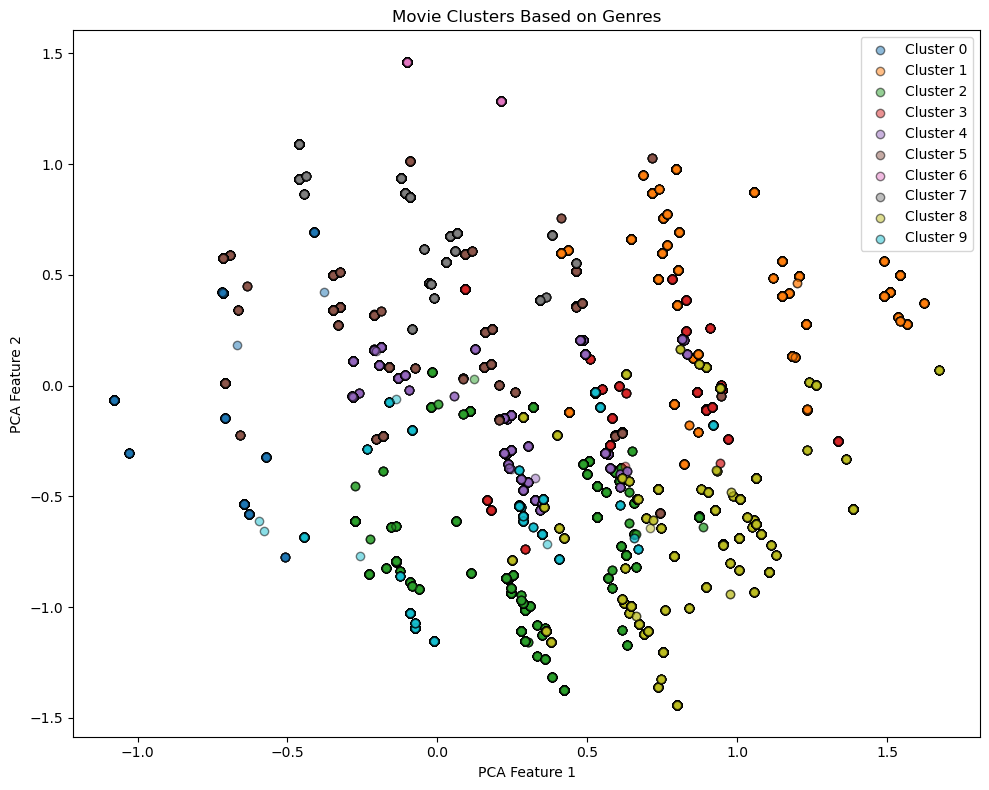

In [48]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np


pca = PCA(n_components=2)
reduced_features = pca.fit_transform(genre_features_sparse.toarray())

# Plot the reduced features colored by their cluster
plt.figure(figsize=(10, 8))

for cluster in range(kmeans.n_clusters):
    cluster_indices = np.where(clusters == cluster)[0]  # Get indices for points in this cluster
    plt.scatter(reduced_features[cluster_indices, 0], reduced_features[cluster_indices, 1], label=f'Cluster {cluster}', alpha=0.5, edgecolor='k')

plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('Movie Clusters Based on Genres')
plt.legend()
plt.tight_layout()
plt.show()



/Users/jguzzo522/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


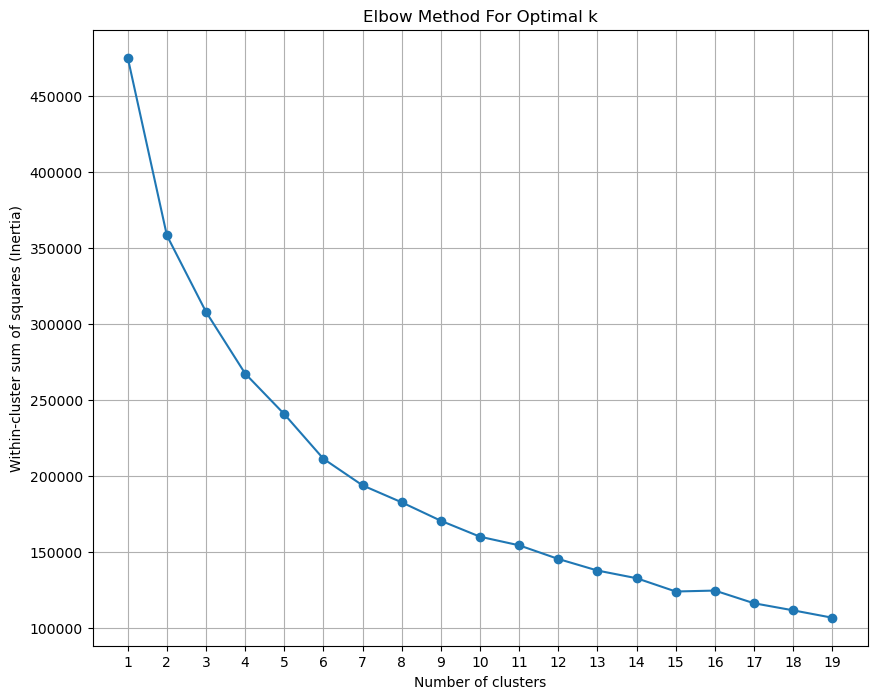

In [49]:
from sklearn.cluster import KMeans

# Calculate the within-cluster sum of squares for different numbers of clusters
inertia = []
for n_clusters in range(1, 20):  #check from 1 to 19 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(genre_features_sparse)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 8))
plt.plot(range(1, 20), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares (Inertia)')
plt.xticks(range(1, 20))
plt.grid(True)
plt.show()


In [50]:
# Re-create the sparse matrix from the original DataFrame
genre_features_sparse = csr_matrix(original_merged_df.loc[:, 'Action':'Western'].values)

# Now run KMeans with the updated number of clusters
kmeans_updated = KMeans(n_clusters=5, random_state=42)
clusters_updated = kmeans_updated.fit_predict(genre_features_sparse)

# Update the cluster labels in the original DataFrame
merged_df['cluster'] = clusters_updated


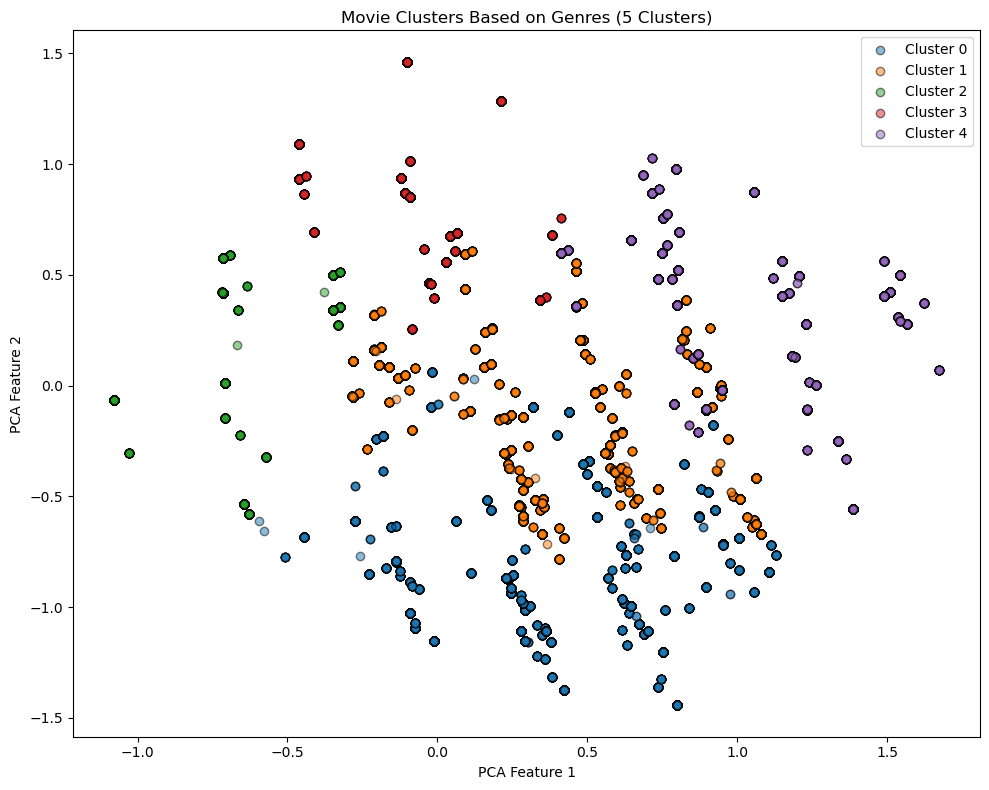

In [51]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(genre_features_sparse.toarray())

# Plot the reduced features colored by their cluster
plt.figure(figsize=(10, 8))

for cluster in np.unique(clusters_updated):
    cluster_indices = np.where(clusters_updated == cluster)[0]
    plt.scatter(reduced_features[cluster_indices, 0], reduced_features[cluster_indices, 1], label=f'Cluster {cluster}', alpha=0.5, edgecolor='k')

plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('Movie Clusters Based on Genres (5 Clusters)')
plt.legend()
plt.tight_layout()
plt.show()


In [52]:

#centroids of the clusters
centroids = kmeans_updated.cluster_centers_

#  genre distribution of the centroids:
centroid_genre_distribution = pd.DataFrame(centroids, columns=genre_features.columns)
print(centroid_genre_distribution)


     Action  Adventure  Animation  Children    Comedy     Crime  Documentary  \
0  0.087481   0.191528   0.152530  0.153254  0.973303  0.139737     0.002714   
1  0.124384   0.245984   0.056472  0.075103  0.000000  0.085078     0.008786   
2  0.000000   0.000015   0.000000  0.000000  0.883570  0.998614     0.000000   
3  0.995268   0.032178   0.000000  0.000000  0.001814  0.973855     0.000000   
4  0.956926   0.672889   0.019792  0.014348  0.015975  0.024851     0.000000   

      Drama   Fantasy  Film-Noir    Horror      IMAX   Musical   Mystery  \
0  0.250194  0.193673   0.000000  0.020003  0.006538  0.073009  0.013826   
1  0.790176  0.117888   0.004930  0.077205  0.031651  0.022096  0.219422   
2  0.917434  0.000090   0.004685  0.026091  0.000000  0.002214  0.058494   
3  0.912378  0.000000   0.003312  0.012579  0.170117  0.000000  0.166805   
4  0.005000  0.017425   0.001420  0.060618  0.163097  0.000000  0.016863   

    Romance    Sci-Fi  Thriller       War   Western  
0  0.382

In [53]:
# For each cluster, calculate the mean of each genre feature
cluster_genre_means = original_merged_df.groupby('cluster')[genre_features.columns].mean()

print(cluster_genre_means)


           Action  Adventure  Animation  Children    Comedy     Crime  \
cluster                                                                 
0        0.000000   0.000017   0.000000  0.000132  0.965100  0.998480   
1        0.995847   0.685260   0.005630  0.000308  0.025844  0.025721   
2        0.067528   0.044471   0.065884  0.022940  0.888550  0.233705   
3        0.024543   0.380675   0.017615  0.014741  0.016878  0.000000   
4        0.213117   0.119281   0.018612  0.030208  0.000000  0.187452   
5        0.004869   0.000000   0.000452  0.001004  0.029164  0.306044   
6        1.000000   0.000000   0.000000  0.000000  0.000000  1.000000   
7        1.000000   0.040169   0.000000  0.000000  0.002159  0.967245   
8        0.210297   0.888074   0.456254  0.575625  0.383711  0.010937   
9        0.038471   0.001026   0.000427  0.004959  0.641788  0.001624   

         Documentary     Drama   Fantasy  Film-Noir    Horror      IMAX  \
cluster                                         

In [54]:
# find top-rated movies
for cluster_num in range(kmeans_updated.n_clusters):
    # Filter the DataFrame for the current cluster
    top_movies = original_merged_df[original_merged_df['cluster'] == cluster_num]

    # Group by title, calculate the mean rating, and sort the movies by rating
    top_movies = top_movies.groupby('title')['rating'].mean().sort_values(ascending=False).head(5)
    
    print(f"Top Movies in Cluster {cluster_num}:\n{top_movies}\n")



Top Movies in Cluster 0:
title
Going Places (Valseuses, Les) (1974)                     5.000000
Man Bites Dog (C'est arrivé près de chez vous) (1992)    4.500000
Infernal Affairs (Mou gaan dou) (2002)                   4.333333
Departed, The (2006)                                     4.252336
Wild Tales (2014)                                        4.250000
Name: rating, dtype: float64

Top Movies in Cluster 1:
title
Logan (2017)                                                                      4.280000
Star Wars: Episode IV - A New Hope (1977)                                         4.231076
Yojimbo (1961)                                                                    4.230769
Star Wars: Episode V - The Empire Strikes Back (1980)                             4.215640
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    4.207500
Name: rating, dtype: float64

Top Movies in Cluster 2:
title
Crossing Delancey (1988)                                   5.0

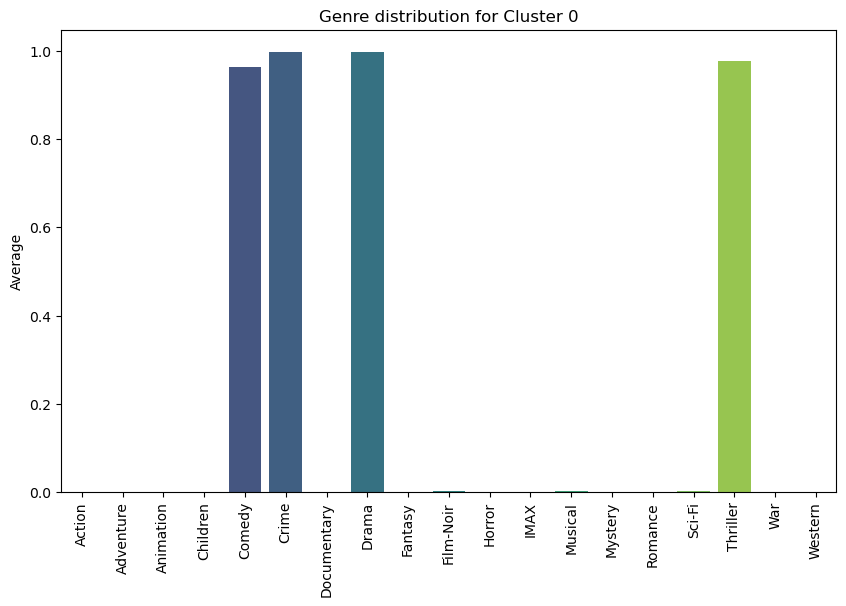

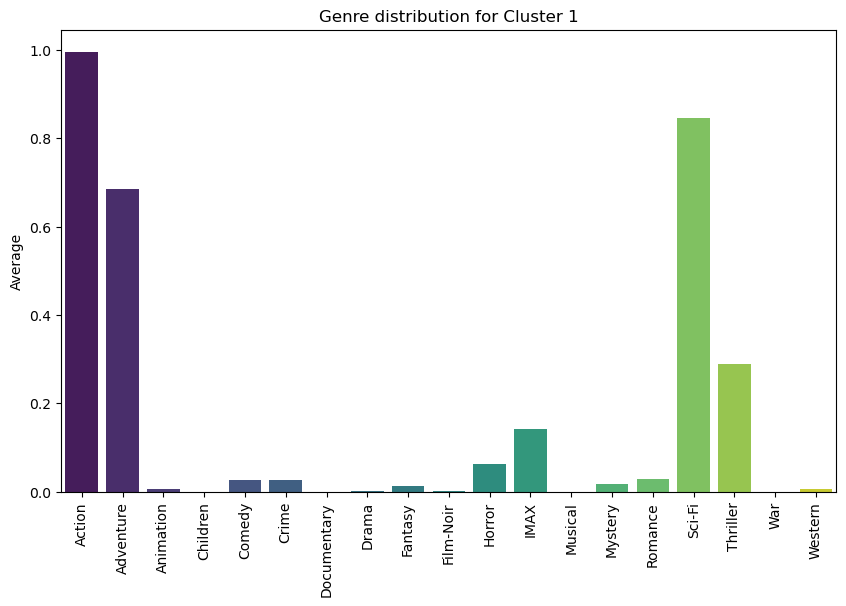

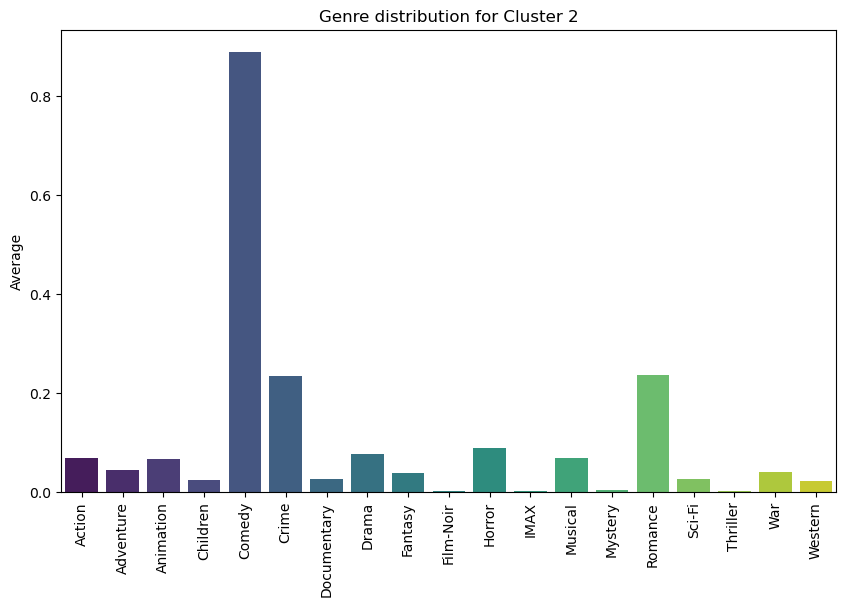

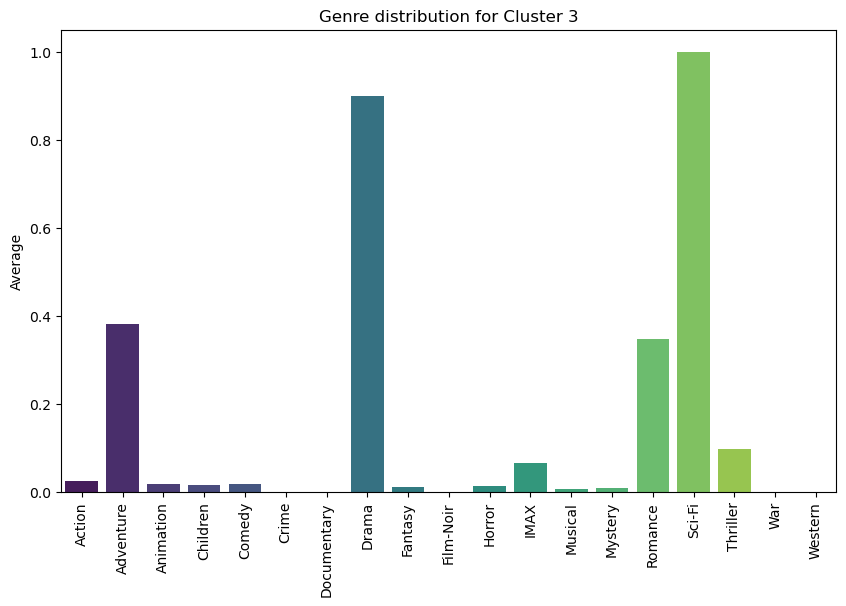

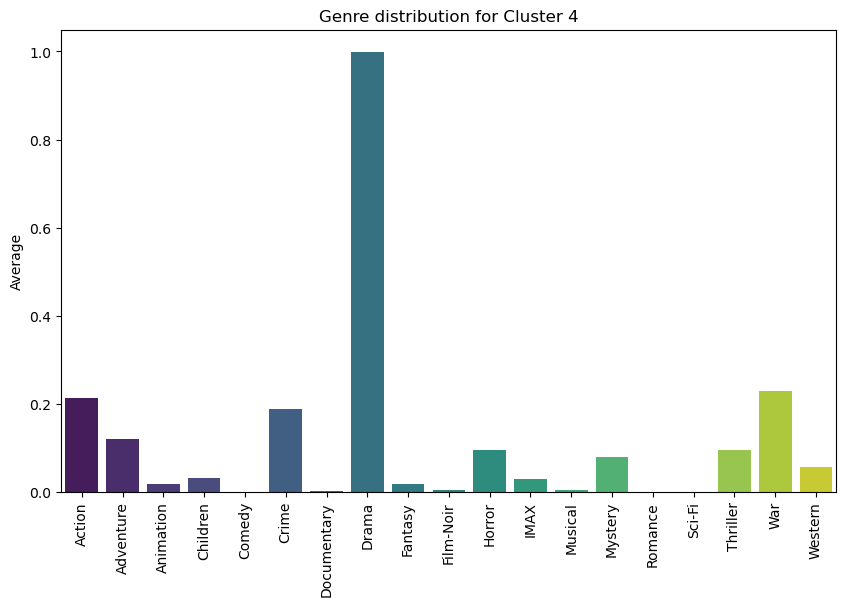

In [55]:
import seaborn as sns

#  distribution of genres in each cluster
for cluster_num in range(kmeans_updated.n_clusters):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=cluster_genre_means.columns, y=cluster_genre_means.loc[cluster_num], palette="viridis")
    plt.title(f'Genre distribution for Cluster {cluster_num}')
    plt.xticks(rotation=90)
    plt.ylabel('Average')
    plt.show()


# Conclusions

## Model Evaluation
The streaming service should leverage the SVD Grid Search methodology for making movie recommendations to existing users. This approach has demonstrated the optimal balance between precision and recall, ensuring that the model recommends movies that users are likely to enjoy while avoiding the mistake of suggesting poorly rated movies under the assumption that they would be highly rated. Moreover, the SVD Grid Search model exhibits higher accuracy compared to the basic SVD model. The superior precision and recall metrics in comparison to the LightFM model further indicate that the SVD Grid Search model is less likely to overlook relevant movie recommendations.

Utilizing the SVD Grid Search methodology ensures that recommendations provided to users are not only useful but also highly rated. Below is an example illustrating how the movie recommendation system would operate:

To address the cold start problem, the streaming service should also consider leveraging K-Means Clustering as a powerful resource. Given that the cold start problem primarily affects new users for whom there is limited or no prior rating information available, K-Means clustering enables an analysis not only of ratings from the entire database but also other factors such as movie genres, actors, directors, and user demographics. By clustering movies based on various features, the system can offer initial recommendations to new users based on the characteristics of similar groups of movies. This approach effectively mitigates the cold start problem by providing relevant recommendations even in the absence of explicit user ratings.

Additionally, alongside K-Means clustering, the streaming service could implement a 'Popularity-Based Method' to offer popular movies to new users. By curating a list of the highest-rated movies from the dataset, known as the 'Highest Rated Movies' list, new users can explore and select movies of interest. Moreover, leveraging this method, the service can easily create subcategories to recommend popular movies by genre. This approach allows users to discover movies across different genres and select the ones that align with their preferences, even without prior knowledge of their favorite genres.

Overall, by integrating both the SVD Grid Search methodology and K-Means clustering along with a Popularity-Based Method, the streaming service can provide comprehensive and tailored movie recommendations to both existing and new users, enhancing the overall user experience.

### Limitations and Next Steps

The SVD Grid Search method has several limitations. One such drawback is the significant time required for data analysis. The initial grid search process can be extremely time-consuming as it explores various parameter combinations to determine the optimal parameters for the SVD model. However, once the initial grid search is completed and the optimal parameters are selected, the model's performance is comparable to that of the regular SVD model.

Another limitation is that the SVD Grid Search method primarily focuses on matrix factorization using user-item interaction data. It may not directly integrate additional variables or features, such as user demographics or item attributes, into the recommendation process. This limitation hinders its ability to consider multiple factors simultaneously when making recommendations.

Due to these limitations, certain features such as 'tags' or 'decade' were not fully analyzed. Moreover, user-specific data, including demographics like age, was not considered in the analysis. Incorporating demographic information could be crucial, as user preferences may vary based on factors such as age. For instance, younger users may prefer children's movies, whereas older users without young children may perfer dramas or action movies.

Additionally, limitations for the clustering analysis for the cold start problem include solely analyzing genre and movie rating data. Furthermore, some movies have multiple genres, and only the most relevant genre was assigned to each movie during the analysis, which could impact clustering results. Further analysis could involve combining tags and genres to provide more in-depth insights into the types of movies within each cluster. Similarly, similar to the limitations of the SVD Grid Search method, gathering information about new users such as age, marital status, children status, and occupation could enhance the clustering analysis by providing additional context for movie recommendations. 

# Recommendations